In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
import sasc.config
import numpy as np
import re
import sasc.viz
from collections import defaultdict
from copy import deepcopy
from sasc import config
import pandas as pd
from sasc import analyze_helper

pilot_name = 'pilot_story_data.pkl'
# pilot_name = 'pilot3_story_data.pkl'
# pilot_name = 'pilot4_story_data.pkl'

stories_data_dict = joblib.load(
    join(config.RESULTS_DIR, 'processed', pilot_name))
if pilot_name == 'pilot_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20230504')
elif pilot_name == 'pilot3_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20231106')
elif pilot_name == 'pilot4_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20240509')

# pilot_data_dir = join(sasc.config.FMRI_DIR, 'story_data/20230504')
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {k: np.load(join(pilot_data_dir, k)) for k in tqdm(resp_np_files)}
stories_data_dict = joblib.load(
    join(config.RESULTS_DIR, 'processed', pilot_name))

100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Note that these function use absolute timing indexes rather than trimmed ones. This works out because they never have to reference the paragraph splits.

### Plot annotated response curves and aggregate word_chunk_deltas

In [2]:
word_chunk_deltas = []
for story_num in tqdm(range(6)):
    paragraphs = stories_data_dict["story_text"][story_num].split("\n\n")
    prompts = stories_data_dict["prompts"]
    t = deepcopy(stories_data_dict["timing"][story_num])
    # t['time_running'] = t['time_running'] - 10

    # these must be passed same timing
    word_chunks = analyze_helper._get_word_chunks(t)
    # word_chunks = word_chunks[5:-5]
    start_times, end_times = analyze_helper.get_start_end_indexes_for_paragraphs(
        t, paragraphs)

    # example_ngrams and word_chunks
    ps = prompts[story_num]
    example_ngrams_list = sum(
        [analyze_helper.find_all_examples_within_quotes(x) for x in ps], []
    )
    word_chunks_contain_example_ngrams = np.zeros(len(word_chunks))
    for i, wc in enumerate(word_chunks):
        for ngram in example_ngrams_list:
            if any([ngram in w for w in wc]):
                word_chunks_contain_example_ngrams[i] = 1
                break

    # get resp curves
    rows = stories_data_dict["rows"][story_num]
    voxel_nums = rows["voxel_num"]
    expls = rows["expl"]
    r_curves = resps_dict[
        stories_data_dict["story_name_new"][story_num].replace('_resps', '')
    ].T[voxel_nums]

    for voxel_num in range(17):
        expl_voxel = expls[voxel_num]
        voxel_resp = r_curves[voxel_num]
        word_chunk_deltas.append(
            sasc.analyze_helper.compute_word_chunk_deltas_for_single_paragraph(
                start_times,
                end_times,
                voxel_resp,
                word_chunks_contain_example_ngrams,
                voxel_num,
            ))
        sasc.viz.plot_annotated_resp(
            voxel_num,
            word_chunks,
            voxel_resp,
            expl_voxel,
            start_times,
            end_times,
            stories_data_dict,
            expls,
            story_num,
            word_chunks_contain_example_ngrams,
            annotate_texts=False,
            plot_key_ngrams=False,
        )
    analyze_helper.save_figs_to_single_pdf(
        filename=join(sasc.config.RESULTS_DIR,
                      'figs/curves',
                      f'{stories_data_dict["story_name_new"][story_num][3:-10]}_curves.pdf')
    )
    plt.close("all")


# Plot ngram delta
means = []
sems = []
delta_offsets = [1, 2, 3, 4, 5]
for i in delta_offsets:
    deltas = sum([x[i] for x in word_chunk_deltas], [])
    # plt.hist(deltas, label='Delta ' + str(i), alpha=0.5)
    # plt.axvline(np.mean(deltas), linewidth=1, color=f'C{i - 1}')

    means.append(np.mean(deltas))
    sems.append(np.std(deltas) / np.sqrt(len(deltas)))
    print(f'Delta {i} mean: {means[-1]:0.4f} +/- {sems[-1]:0.4f}')
# plt.legend()
delta_offsets = 2 * np.array(delta_offsets)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:12<00:00,  2.15s/it]

Delta 1 mean: 0.1107 +/- 0.0594
Delta 2 mean: 0.1489 +/- 0.0697
Delta 3 mean: 0.1794 +/- 0.0747
Delta 4 mean: 0.1315 +/- 0.0828
Delta 5 mean: 0.0528 +/- 0.0836


<>:10: DeprecationWarning: invalid escape sequence '\s'
<>:10: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_1335483/2721601888.py:10: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Voxel response change ($\sigma_f$)')


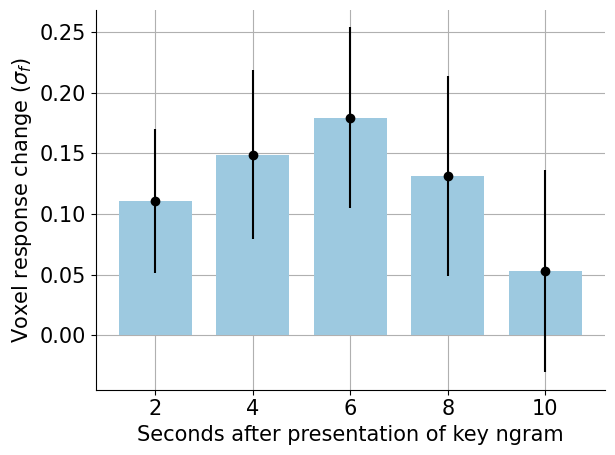

In [3]:
# barplot of means
# sns.
plt.grid(zorder=-100)
plt.bar(delta_offsets, means, color='#9dc9e0', zorder=100, width=1.5, alpha=1)
plt.errorbar(delta_offsets, means, yerr=sems,
             fmt='o', color='black', zorder=101)
plt.xticks(delta_offsets)

plt.xlabel('Seconds after presentation of key ngram')
plt.ylabel('Voxel response change ($\sigma_f$)')
plt.savefig(join(sasc.config.RESULTS_DIR, 'figs', 'misc',
            'pilot_default_ngram_deltas.pdf'), bbox_inches='tight')
plt.show()